In [23]:
import pandas as pd
import numpy as np

# Load dataset
path = 'data.csv'

df = pd.read_csv(path)
print(df.head())
print("\nColumns:\n", df.columns.tolist())
print("\nSummary Stats:\n", df.describe(include='all'))


   Customer ID  Avg Monthly Sent Emails\n(Jan-Oct)  \
0            1                               86394   
1            2                               34309   
2            3                               42175   
3            4                                2074   
4            5                               20695   

  Avg Monthly Sent Emails \n(Nov-Dec)  Avg Monthly Subscribers\n  \
0                             184,019                      14709   
1                              63,129                       8209   
2                              91,942                      17454   
3                               2,489                       1411   
4                              37,872                      11251   

         Email Provider  Avg Monthly Opened Emails  \
0  Third Party Solution                    2591.82   
1  Third Party Solution                     343.09   
2  Third Party Solution                     421.75   
3         Shopify Email                     186.66

In [24]:
for i, col in enumerate(df.columns):
    print(i, repr(col))


0 'Customer ID'
1 'Avg Monthly Sent Emails\n(Jan-Oct)'
2 'Avg Monthly Sent Emails \n(Nov-Dec)'
3 'Avg Monthly Subscribers\n'
4 'Email Provider'
5 'Avg Monthly Opened Emails'
6 'Avg Mthly Sales $ \n(via Email Campaigns)'
7 'Avg Mthly Sales $\n(Total)'


# Shopify Email Product Analysis and Pricing Strategy

This notebook analyzes a dataset of Shopify merchants' email marketing activity. We clean the raw data, compute key metrics (open rates, revenue per email, cost per email, margins), compare performance across providers, explore an unlimited pricing plan, and draw on external benchmarks and competitor pricing to recommend improvements for Shopify Email.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
# The dataset is located in the same directory as this notebook
raw_df = pd.read_csv('data.csv')

# Rename columns for easier reference
raw_df = raw_df.rename(columns={
    'Avg Monthly Sent Emails\n(Jan-Oct)': 'sent_jan_oct',
    'Avg Monthly Sent Emails \n(Nov-Dec)': 'sent_nov_dec',
    'Avg Monthly Subscribers\n': 'subscribers',
    'Email Provider': 'provider',
    'Avg Monthly Opened Emails': 'opens',
    'Avg Mthly Sales $ \n(via Email Campaigns)': 'sales_email',
    'Avg Mthly Sales $\n(Total)': 'sales_total'
})

# Display the first few rows to inspect the data structure
raw_df.head()

,Customer ID,sent_jan_oct,sent_nov_dec,subscribers,provider,opens,sales_email,sales_total
0,1,86394,"184,019",14709,Third Party Solution,2591.82,"$53,561","$5,356,100"
1,2,34309,"63,129",8209,Third Party Solution,343.09,"$16,399","$273,317"
2,3,42175,"91,942",17454,Third Party Solution,421.75,"$54,440","$907,333"
3,4,2074,"2,489",1411,Shopify Email,186.66,$672,"$22,400"
4,5,20695,"37,872",11251,Third Party Solution,620.85,"$17,800","$445,000"


In [26]:
# Clean numeric columns by removing commas and dollar signs
clean_df = raw_df.copy()

# Function to clean numbers
for col in ['sent_jan_oct', 'sent_nov_dec', 'subscribers', 'opens']:
    # Remove commas and convert to float
    clean_df[col] = clean_df[col].astype(str).str.replace(',', '').astype(float)

# Clean sales columns: remove $ and commas
clean_df['sales_email'] = clean_df['sales_email'].astype(str).str.replace('[$,]', '', regex=True).astype(float)
clean_df['sales_total'] = clean_df['sales_total'].astype(str).str.replace('[$,]', '', regex=True).astype(float)

# Fill missing Nov-Dec values with Jan-Oct values (assume similar volume when missing)
clean_df['sent_nov_dec'] = clean_df['sent_nov_dec'].fillna(clean_df['sent_jan_oct'])

# Compute weighted average sent emails across the year
clean_df['avg_sent'] = (10 * clean_df['sent_jan_oct'] + 2 * clean_df['sent_nov_dec']) / 12

# Compute open rate
clean_df['open_rate'] = clean_df['opens'] / clean_df['avg_sent']

# Compute revenue per email and per subscriber
clean_df['revenue_per_email'] = clean_df['sales_email'] / clean_df['avg_sent']
clean_df['revenue_per_subscriber'] = clean_df['sales_email'] / clean_df['subscribers']

# Cost per email and gross margin (Shopify cost and payment revenue)
COST_PER_EMAIL = 0.0003
PAYMENT_FEE_RATE = 0.005  # 0.5% of merchant GMV
clean_df['monthly_cost'] = COST_PER_EMAIL * clean_df['avg_sent']
clean_df['payment_revenue'] = PAYMENT_FEE_RATE * clean_df['sales_email']
clean_df['gross_margin'] = clean_df['payment_revenue'] - clean_df['monthly_cost']

# BFCM/holiday period metrics (4x volume, 1.3x revenue)
clean_df['bfcm_sent'] = 4 * clean_df['sent_nov_dec']
clean_df['bfcm_sales_email'] = 1.3 * clean_df['sales_email']
clean_df['bfcm_monthly_cost'] = COST_PER_EMAIL * clean_df['bfcm_sent']
clean_df['bfcm_payment_revenue'] = PAYMENT_FEE_RATE * clean_df['bfcm_sales_email']
clean_df['bfcm_gross_margin'] = clean_df['bfcm_payment_revenue'] - clean_df['bfcm_monthly_cost']

# Summarise key metrics by provider
group_cols = ['avg_sent', 'open_rate', 'revenue_per_email', 'revenue_per_subscriber', 'monthly_cost', 'gross_margin']
summary_by_provider = clean_df.groupby('provider')[group_cols].mean().reset_index()

summary_by_provider

,provider,avg_sent,open_rate,revenue_per_email,revenue_per_subscriber,monthly_cost,gross_margin
0,Shopify Email,15284.285309,0.065086,0.679864,0.622742,4.585286,9.818651
1,Third Party Solution,60515.121515,0.017112,0.772250,3.119645,18.154536,177.381743


In [27]:
# Analyze distribution of monthly cost for Shopify Email customers
shopify_df = clean_df[clean_df['provider'] == 'Shopify Email'].copy()

# Quantiles of the pay-as-you-go monthly cost
cost_quantiles = shopify_df['monthly_cost'].quantile([0.5, 0.75, 0.9, 0.95]).round(2)
cost_quantiles_df = cost_quantiles.reset_index()
cost_quantiles_df.columns = ['quantile', 'monthly_cost_usd']

# Evaluate unlimited pricing: test 75th and 90th percentile as fixed subscription price
price_75 = cost_quantiles.loc[0.75]
price_90 = cost_quantiles.loc[0.90]

# Compute revenue difference for each price
shopify_df['revenue_diff_75'] = price_75 - shopify_df['monthly_cost']
shopify_df['revenue_diff_90'] = price_90 - shopify_df['monthly_cost']

# Summarize total monthly margin difference if all Shopify merchants switched to unlimited plan
unlimited_summary = pd.DataFrame({
    'price_point': ['75th percentile', '90th percentile'],
    'subscription_price': [price_75, price_90],
    'net_margin_change_total': [shopify_df['revenue_diff_75'].sum(), shopify_df['revenue_diff_90'].sum()]
})

cost_quantiles_df, unlimited_summary

(   quantile  monthly_cost_usd
 0      0.50              2.66
 1      0.75              4.53
 2      0.90             14.47
 3      0.95             19.42,
        price_point  subscription_price  net_margin_change_total
 0  75th percentile                4.53                -110.5159
 1  90th percentile               14.47               19759.5441)

In [28]:
# Competitor pricing tiers and features (manually extracted from the research slide)
competitor_data = pd.DataFrame({
    'provider': ['Klaviyo', 'Omnisend', 'Mailchimp'],
    'free_tier': [
        '250 profiles, 500 emails, 150 SMS',
        '250 contacts, 500 emails, 60 SMS',
        '500 contacts, 1K emails (ads)'
    ],
    'starter_price': [
        'US$20/mo (251–500 profiles, 5K emails)',
        'US$16/mo (up to 500 contacts, 6K emails)',
        'US$13–20/mo depending on features & contacts (5K–6K emails)'
    ],
    'unlimited_plan': [
        'Unlimited sends tied to active profiles (e.g., $150/mo at 10K; enterprise custom pricing)',
        'US$59/mo for unlimited sends up to 2,500 contacts; scalable tiers beyond',
        'US$350+/mo for Premium: unlimited contacts & higher sends'
    ]
})

# External email benchmarks for 2025 (from industry sources)
benchmark_data = pd.DataFrame({
    'metric': ['Open Rate', 'Click-Through Rate', 'Click-To-Open Rate', 'Unsubscribe Rate', 'Bounce Rate'],
    'benchmark_2025': ['~42.35%', '~2.00%', '~5.63%', '~0.08%–0.50%', '<2% (ideal <1%)'],
    'range_or_notes': [
        '~22.5%–59.7% across industries',
        '~0.77%–4.36%',
        '~2.93%–10.71%',
        '<0.2% = excellent; <0.5% = good',
        'Hard + soft bounces combined'
    ],
    'sources': [
        'ActiveCampaign, Growth-onomics',
        'MailerLite, Growth-onomics',
        'MailerLite, Growth-onomics',
        'ActiveCampaign, WebFX',
        'ActiveCampaign, WebFX'
    ]
})

competitor_data, benchmark_data

(    provider                          free_tier  \
 0    Klaviyo  250 profiles, 500 emails, 150 SMS   
 1   Omnisend   250 contacts, 500 emails, 60 SMS   
 2  Mailchimp      500 contacts, 1K emails (ads)   
 
                                        starter_price  \
 0             US$20/mo (251–500 profiles, 5K emails)   
 1           US$16/mo (up to 500 contacts, 6K emails)   
 2  US$13–20/mo depending on features & contacts (...   
 
                                       unlimited_plan  
 0  Unlimited sends tied to active profiles (e.g.,...  
 1  US$59/mo for unlimited sends up to 2,500 conta...  
 2  US$350+/mo for Premium: unlimited contacts & h...  ,
                metric   benchmark_2025                   range_or_notes  \
 0           Open Rate          ~42.35%   ~22.5%–59.7% across industries   
 1  Click-Through Rate           ~2.00%                     ~0.77%–4.36%   
 2  Click-To-Open Rate           ~5.63%                    ~2.93%–10.71%   
 3    Unsubscribe Rate     ~0.0

In [29]:
unlimited_summary

,price_point,subscription_price,net_margin_change_total
0,75th percentile,4.53,-110.5159
1,90th percentile,14.47,19759.5441


In [30]:
# Set matplotlib backend to inline to avoid serialization errors
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')

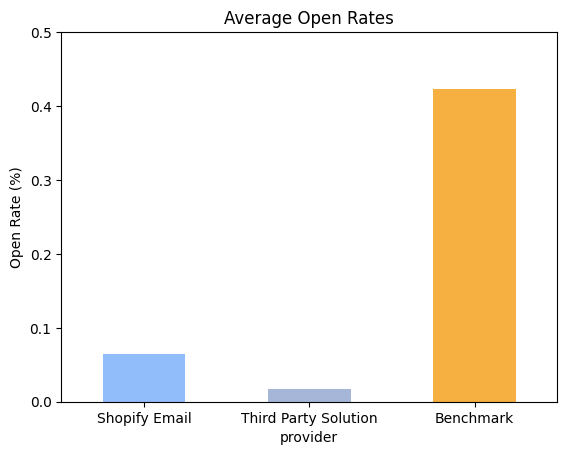

In [31]:
import matplotlib.pyplot as plt

# assume df is your cleaned DataFrame with computed metrics
# group by provider type
summary = clean_df.groupby('provider').agg({
    'open_rate':'mean'
}).rename(index={'Shopify':'Shopify', 'Third Party':'Third‑Party'})

# add benchmark
summary.loc['Benchmark'] = 0.4235  # 42.35% benchmark

# plot
summary['open_rate'].plot(kind='bar', color=['#91BDFB', '#A6B6D8', '#F5B041'])
plt.title('Average Open Rates')
plt.ylabel('Open Rate (%)')
plt.ylim(0, 0.5)
plt.xticks(rotation=0)
plt.show()

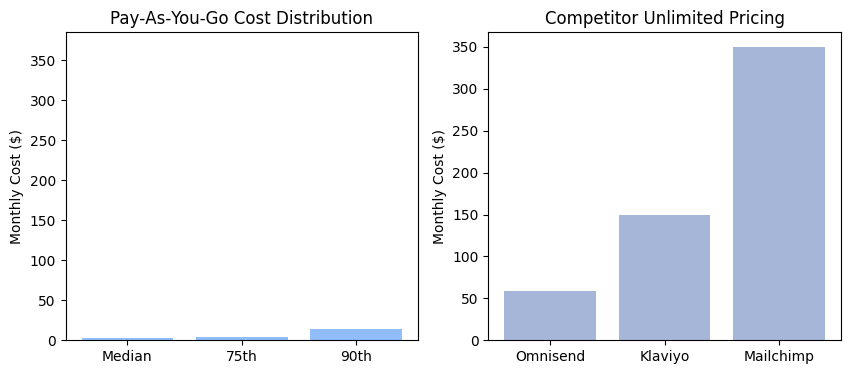

In [32]:
# monthly_cost is cost per merchant based on pay‑as‑you‑go
cost_quants = clean_df[clean_df['provider'] == 'Shopify Email']['monthly_cost'].quantile([0.5, 0.75, 0.90])
competitor = pd.Series({'Omnisend': 59, 'Klaviyo': 150, 'Mailchimp': 350})

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# left bar chart for Shopify cost percentiles
ax[0].bar(['Median','75th','90th'], cost_quants.values, color='#91BDFB')
ax[0].set_title('Pay‑As‑You‑Go Cost Distribution')
ax[0].set_ylabel('Monthly Cost ($)')
ax[0].set_ylim(0, competitor.max()*1.1)

# right bar chart for competitor unlimited plans
ax[1].bar(competitor.index, competitor.values, color='#A6B6D8')
ax[1].set_title('Competitor Unlimited Pricing')
ax[1].set_ylabel('Monthly Cost ($)')
plt.show()